In [22]:
# Import necessary packages
import pandas as pd
import numpy as np
from sklearn import feature_selection
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import gc

import matplotlib.pylab as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [126]:
# Import the training data
train = pd.read_csv('training_new.csv')
train = pd.DataFrame(train)

In [127]:
# Seperate input and target variable for training set
x_columns = [x for x in train.columns if x not in ['Unnamed: 0', 'TARGET', 'SK_ID_CURR']]
x = train[x_columns]
y = train[['TARGET']]

In [ ]:
# Train a baseline model with parameters given in exercise
model_1 = RandomForestClassifier(oob_score=True, random_state=10, n_estimators=100, max_depth = 3, min_samples_split = 200, min_samples_leaf = 50)
model_1.fit(x,y)
print(model_1.oob_score_)
y_predprob = model_1.predict_proba(x)[:,1]
print("AUC Score (Train): %f" % metrics.roc_auc_score(y, y_predprob))

In [ ]:
# Find the optimal 'n_estimators'
param_test1 = {'n_estimators':range(50, 501,50)}
gsearch1 = GridSearchCV(estimator = RandomForestClassifier(n_jobs = -1), 
                       param_grid = param_test1, scoring='roc_auc',cv=5)
gsearch1.fit(x,y)
print(gsearch1.cv_results_)
print(gsearch1.best_params_)
print("best accuracy:%f" % gsearch1.best_score_)

In [ ]:
# Find the optimal 'max_depth' and 'min_samples_split'
param_test2 = {'max_depth':range(1,15,1), 'min_samples_split':range(10,201,10)}
gsearch2 = GridSearchCV(estimator = RandomForestClassifier(n_jobs = -1, n_estimators= 350, 
                                  min_samples_leaf=20,max_features='sqrt' ,oob_score=True, random_state=10),
   param_grid = param_test2, scoring='roc_auc', cv=5)
gsearch2.fit(x,y)
print(gsearch2.cv_results_)
print(gsearch2.best_params_)
print("best accuracy:%f" % gsearch2.best_score_)

In [ ]:
# Find the optimal 'min_samples_split' and 'min_samples_leaf'
param_test3 = {'min_samples_split':range(2,10,1), 'min_samples_leaf':range(10,100,10)}
gsearch3 = GridSearchCV(estimator = RandomForestClassifier(n_jobs = -1, n_estimators= 350, max_depth=12,
                                  max_features='sqrt' ,oob_score=True, random_state=10),
   param_grid = param_test3, scoring='roc_auc', cv=5)
gsearch3.fit(x,y)
print(gsearch3.cv_results_)
print(gsearch3.best_params_)
print("best accuracy:%f" % gsearch3.best_score_)

In [ ]:
# Find the optimal "max_features"
param_test4 = {'max_features':range(10,20,1)}
gsearch4 = GridSearchCV(estimator = RandomForestClassifier(n_jobs = -1, n_estimators = 350, max_depth = 12, min_samples_split = 2,
                                  min_samples_leaf = 50, oob_score = True, random_state = 10),
   param_grid = param_test4, scoring='roc_auc', cv=5)
gsearch4.fit(x,y)
print(gsearch4.cv_results_)
print(gsearch4.best_params_)
print("best accuracy:%f" % gsearch4.best_score_)

In [ ]:
# Fit the model with optimal parameters
model_2 = RandomForestClassifier(n_estimators = 350, max_depth = 12, min_samples_split = 2,
                                  min_samples_leaf=50, max_features = 17, oob_score = True, random_state = 10)
model_2.fit(x,y) 
print(model_2.oob_score_)
y_predprob = model_2.predict_proba(x)[:,1]
print("AUC Score (Train): %f" % metrics.roc_auc_score(y, y_predprob))

Training Data Shape:  (215253, 240)


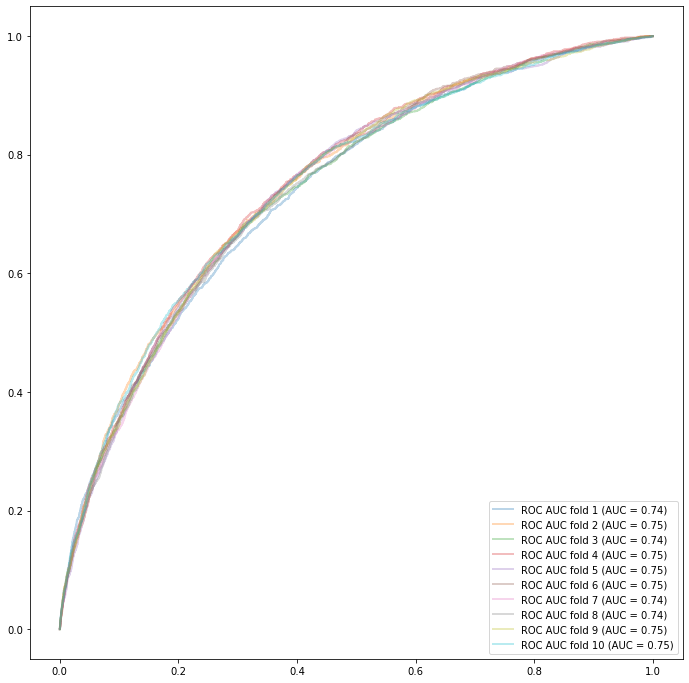

In [12]:
# K-fold validation for model with optimized parameters

# make plot
fig1 = plt.figure(figsize=[12,12])
ax1 = fig1.add_subplot(111,aspect = 'equal')

# Extract the ids
ids = train['SK_ID_CURR']

# Extract the labels for training
labels = train['TARGET']

features = train.drop(columns = ['SK_ID_CURR', 'TARGET'])

print('Training Data Shape: ', features.shape)

# Extract feature names
feature_names = list(features.columns)

# Convert to np arrays
training_matrix = np.array(features)

# Create the kfold object
k_fold = KFold(n_splits = 10, shuffle = True, random_state = 50)

# Make our model object
model_opt = RandomForestClassifier(n_estimators = 350, max_depth = 12, min_samples_split = 2,
                                  min_samples_leaf=50, max_features = 17)

# Empty array for feature importances
feature_importance_values = np.zeros(len(feature_names))

tprs = []
aucs = []

#fold counter
i=1

for train,test in k_fold.split(features,labels):
    prob = model_opt.fit(features.iloc[train],labels.iloc[train]).predict_proba(features.iloc[test])[:,1]
    fpr, tpr, t = roc_curve(labels.iloc[test], prob)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC AUC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1
    
plt.legend(loc="lower right")
plt.show()

Training Data Shape:  (215253, 240)


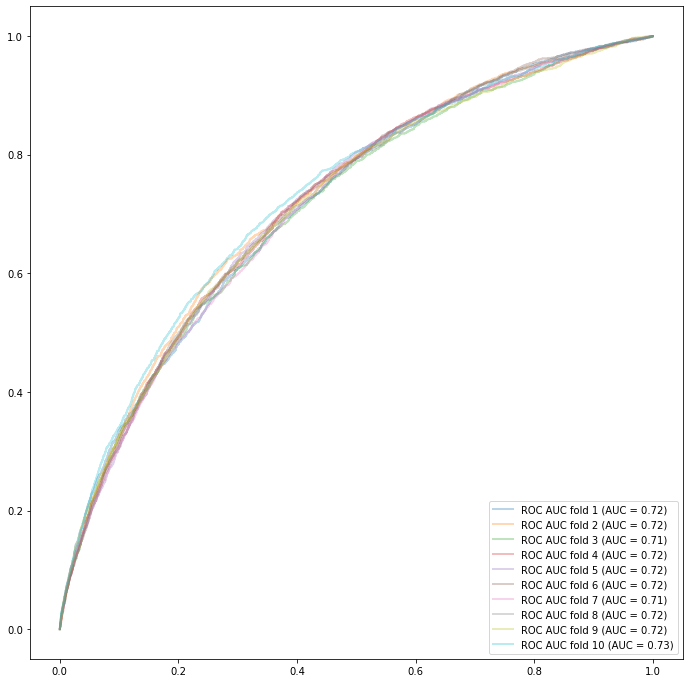

In [79]:
#do k-fold on baseline model with given parameters

# make plot
fig1 = plt.figure(figsize=[12,12])
ax1 = fig1.add_subplot(111,aspect = 'equal')

# Extract the ids
ids = train['SK_ID_CURR']

# Extract the labels for training
labels = train['TARGET']

features = train.drop(columns = ['SK_ID_CURR', 'TARGET'])

print('Training Data Shape: ', features.shape)

# Extract feature names
feature_names = list(features.columns)

# Convert to np arrays
training_matrix = np.array(features)

# Create the kfold object
k_fold = KFold(n_splits = 10, shuffle = True, random_state = 50)

# Make our model object
model = RandomForestClassifier(n_estimators=100, 
                               max_depth = 3, min_samples_split = 200, min_samples_leaf = 50)

# Empty array for feature importances
feature_importance_values = np.zeros(len(feature_names))

tprs = []
aucs = []

#fold counter
i=1

for train,test in k_fold.split(features,labels):
    prob = model.fit(features.iloc[train],labels.iloc[train]).predict_proba(features.iloc[test])[:,1]
    fpr, tpr, t = roc_curve(labels.iloc[test], prob)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC AUC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1
    
plt.legend(loc="lower right")
plt.show()

In [13]:
# K-mean clustering
kmeans = KMeans(n_clusters=10, init= 'k-means++', max_iter = 300, n_init = 10, random_state = 123)
kmeans_results = kmeans.fit(features)

In [14]:
train_clusters = pd.DataFrame(data = {"cluster": kmeans_results.predict(features)} ,index = features.index)
onehotencoder = OneHotEncoder()
one_hotted_train_data = pd.DataFrame(data = onehotencoder.fit_transform(train_clusters[["cluster"]]).toarray() ,index = train_clusters.index)
assert features.shape[0] == one_hotted_train_data.shape[0], "shape is off"
features_with_kmeans = features.join(one_hotted_train_data)

Training Data Shape:  (215253, 250)


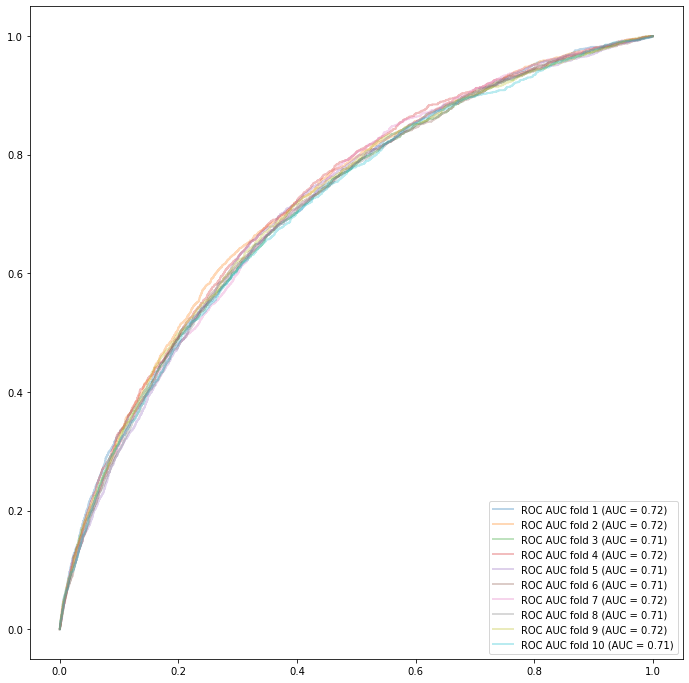

In [16]:
# k-fold validation on baseline model with K-mean clustering

# make plot
fig1 = plt.figure(figsize=[12,12])
ax1 = fig1.add_subplot(111,aspect = 'equal')

# Extract the ids
ids = train['SK_ID_CURR']

# Extract the labels for training
labels = train['TARGET']

features = features_with_kmeans

print('Training Data Shape: ', features.shape)

# Extract feature names
feature_names = list(features.columns)

# Convert to np arrays
training_matrix = np.array(features)

# Create the kfold object
k_fold = KFold(n_splits = 10, shuffle = True, random_state = 50)

#make our model object
model = RandomForestClassifier(n_estimators=100, max_depth = 3, min_samples_split = 200, min_samples_leaf = 50)

# Empty array for feature importances
feature_importance_values = np.zeros(len(feature_names))

tprs = []
aucs = []

#fold counter
i=1

for train,test in k_fold.split(features,labels):
    prob = model.fit(features.iloc[train],labels.iloc[train]).predict_proba(features.iloc[test])[:,1]
    fpr, tpr, t = roc_curve(labels.iloc[test], prob)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC AUC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1
    
plt.legend(loc="lower right")
plt.show()

Training Data Shape:  (215253, 250)


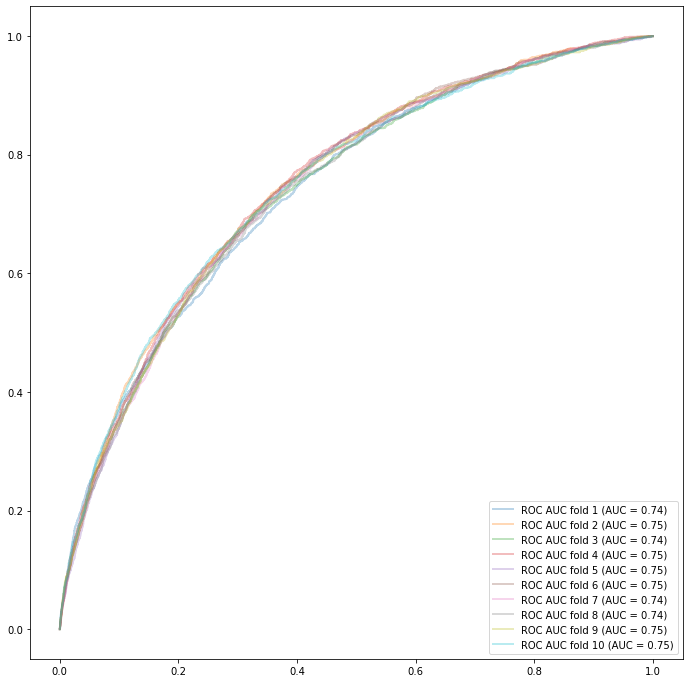

In [19]:
# k-fold validation on model with optimized parameters with K-mean clustering

# make plot
fig1 = plt.figure(figsize=[12,12])
ax1 = fig1.add_subplot(111,aspect = 'equal')

# Extract the ids
ids = train['SK_ID_CURR']

# Extract the labels for training
labels = train['TARGET']

features = features_with_kmeans

print('Training Data Shape: ', features.shape)

# Extract feature names
feature_names = list(features.columns)

# Convert to np arrays
training_matrix = np.array(features)

# Create the kfold object
k_fold = KFold(n_splits = 10, shuffle = True, random_state = 50)

#make our model object
model = RandomForestClassifier(n_estimators = 350, max_depth = 12, min_samples_split = 2, min_samples_leaf=50, max_features = 17)

# Empty array for feature importances
feature_importance_values = np.zeros(len(feature_names))

tprs = []
aucs = []

#fold counter
i=1

for train,test in k_fold.split(features,labels):
    prob = model.fit(features.iloc[train],labels.iloc[train]).predict_proba(features.iloc[test])[:,1]
    fpr, tpr, t = roc_curve(labels.iloc[test], prob)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC AUC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1
    
plt.legend(loc="lower right")
plt.show()

In [131]:
# Import the testing set
test = pd.read_csv('testing_adjusted.csv')
test = pd.DataFrame(test)

# Seperate input and target variable for testing set
x_columns_2 = [x for x in test.columns if x not in ['Unnamed: 0', 'TARGET', 'SK_ID_CURR']]
x_test = test[x_columns_2]
y_test = test[['TARGET']]

# Calculate model with optimized parameters' AUC on Test set
model_opt = RandomForestClassifier(n_estimators = 350, max_depth = 12, min_samples_split = 2, min_samples_leaf=50, max_features = 17)
model_opt.fit(x,y)
y_predprob = model_opt.predict_proba(x_test)[:,1]
print("AUC Score (Test) for optimized model: %f" % metrics.roc_auc_score(y_test, y_predprob))

AUC Score (Test) for optimized model: 0.741150


In [128]:
# View confusion matrix for test data and predictions
model_opt = RandomForestClassifier(n_estimators = 350, max_depth = 12, min_samples_split = 2, min_samples_leaf=50, max_features = 17)
model_opt.fit(x,y)
y_pred_test = model_opt.predict(x_test)
print(confusion_matrix(y_test, y_pred_test))

[[57687 27115]
 [ 2350  5100]]


In [129]:
# View accuracy score
print(accuracy_score(y_test, y_pred_test))

0.6806031305554351


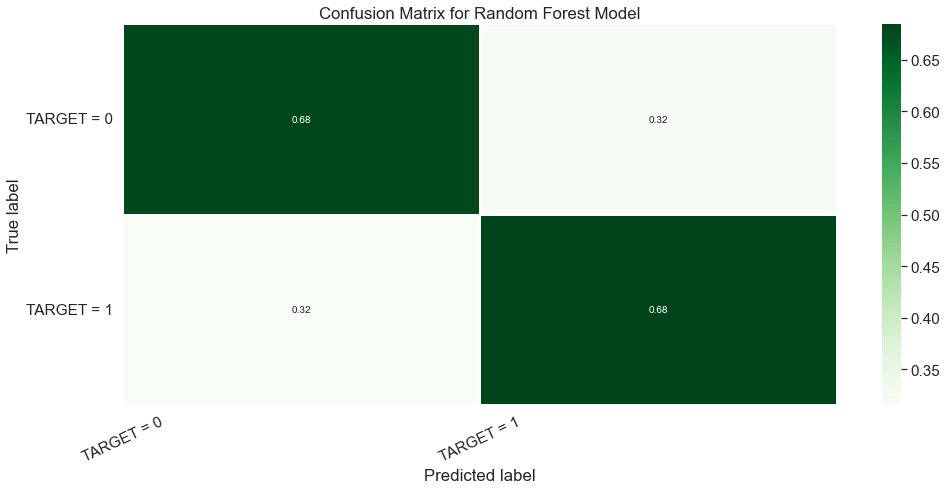

In [130]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['TARGET = 0', 'TARGET = 1']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()